# Lunar Lander AI using REINFORCE (Monte Carlo Policy Gradient)

## Importing needed Libraries

In [2]:
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
import numpy as np

import imageio

import matplotlib.pyplot as plt
import time

## Making Lunar Lander Environments

In [3]:
env_id = "LunarLander-v2"    # flappy bird env id

env = gym.make(env_id, render_mode='rgb_array')      # creating the env
s_size = env.observation_space.shape[0]     # observation space
a_size = env.action_space.n                 # action space

## Observation Space

In [4]:
print("_____OBSERVATION SPACE_____ \n")
print(f"Observation Space: {s_size}")
print(f"Sample Observation Space: {env.observation_space.sample()}")

_____OBSERVATION SPACE_____ 

Observation Space: 8
Sample Observation Space: [-15.864752   -54.685867     1.8251647    3.945921    -3.0143573
   4.7173586    0.70770836   0.3785176 ]


The state is an 8-dimensional vector:
- the coordinates of the lander in `x` & `y`
- its linear velocities in `x` & `y`
- its `angle`
- its `angular velocity`
- two booleans that represent whether each leg is in contact with the ground or not.

## Action Space

In [5]:
print("_____ACTION SPACE_____ \n")
print(f"Action Space: {a_size}")
print(f"Sample Action Space: {env.action_space.sample()}")

_____ACTION SPACE_____ 

Action Space: 4
Sample Action Space: 3


There are four discrete actions available:
- do nothing
- fire left orientation engine,
- fire main engine
- fire right orientation engine.

## Reward Function

- Reward for moving from the top of the screen to the landing pad and coming to rest is about `100-140` points.
- If the lander moves away from the landing pad, it loses reward.
- If the lander crashes, it receives an additional `-100` points.
- If it comes to rest, it receives an additional` +100` points.
- Each leg with ground contact is `+10` points.
- Firing the main engine is `-0.3` points each frame.
- Firing the side engine is `-0.03` points each frame.
- Solved is `200` points.

## Starting State

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

## Defining the Policy (Brain of the AI)
- using <b>REINFORCE</b> (Monte Carlo Policy Gradient Method)

In [6]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        ## Creating Layers of the Neural Network
        # Hidden Layers
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        # Output Layer
        self.fc3 = nn.Linear(h_size*2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)       

Debug the Policy

In [7]:
debug_policy = Policy(s_size, a_size, 24)
state = env.reset()
debug_policy.act(state[0])

(0, tensor([-1.3364], grad_fn=<SqueezeBackward1>))

## Coding the REINFORCE Algorithm

In [8]:
losses = []
avg_scores = []
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        state = state[0]
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_t) 
        n_steps = len(rewards) 

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(gamma*disc_return_t + rewards[t])

        # standardizing returns to make traininig more stable
        eps = np.finfo(np.float32).eps.item()       # smallest representable float
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std()+eps)    # added to std deviation to avoid numerical instabilities

        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        avg_scores.append(np.mean(scores_deque))
        losses.append(policy_loss.item())
        if i_episode % print_every == 0:
            path = f"./contModels/model-{i_episode}.pt"
            torch.save(policy, path)
            print(f"Episode: {i_episode}\tAverage Score: {np.mean(scores_deque)}\tPolicy Loss: {policy_loss.item()}")
        
    return scores

## Defining Hyperparameters

In [9]:
lunarlander_hyperparameters = {
    "h_size": 8,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": .99,
    "lr": 0.1,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

Reviewing the Policy

In [10]:
Policy(s_size, a_size, lunarlander_hyperparameters['h_size'])

Policy(
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)

## Training the Agent

In [11]:
lunarlander_policy = Policy(lunarlander_hyperparameters["state_space"], lunarlander_hyperparameters["action_space"], lunarlander_hyperparameters["h_size"])
# lunarlander_policy = torch.load("./Models/model-10000.pt")
lunarlander_optimizer = optim.Adam(lunarlander_policy.parameters(), lr=lunarlander_hyperparameters["lr"])

In [12]:
scores = reinforce(
    lunarlander_policy,
    lunarlander_optimizer,
    lunarlander_hyperparameters["n_training_episodes"],
    lunarlander_hyperparameters["max_t"],
    lunarlander_hyperparameters["gamma"],
    100,
)

KeyboardInterrupt: 

### Plotting Loss

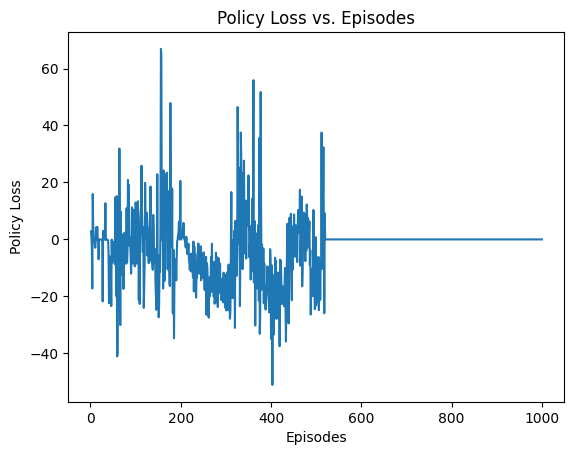

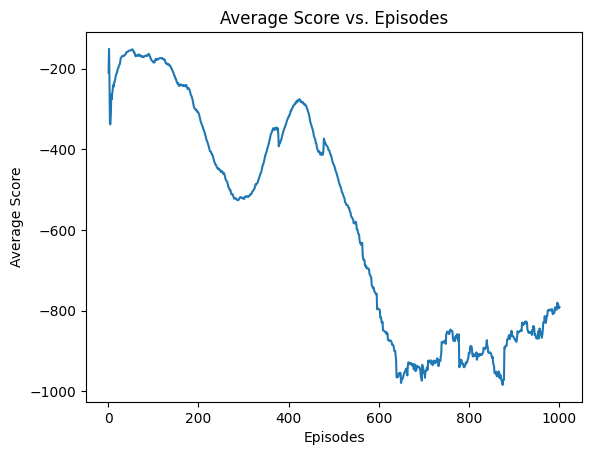

In [ ]:
# Plotting the policy loss with episodes
plt.plot(range(1, lunarlander_hyperparameters["n_training_episodes"]+1), losses)
plt.xlabel('Episodes')
plt.ylabel('Policy Loss')
plt.title('Policy Loss vs. Episodes')
plt.show()
# Plotting the avg score with episodes
plt.plot(range(1, lunarlander_hyperparameters["n_training_episodes"]+1), avg_scores)
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.title('Average Score vs. Episodes')
plt.show()

In [65]:
lunarlander_policy= torch.load( ".\\contModels\\model-100.pt")

eval_env = gym.make(env_id, render_mode='rgb_array')     # creating the eval env

## Define Evaluation Agent

In [66]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    state = state[0]
    step = 0
    terminated = False
    truncated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

### Evaluating The Agent

In [67]:
# lunarlander_policy = torch.load("./Models/model-10000.pt")
evaluate_agent(eval_env,
               lunarlander_hyperparameters["max_t"],
               lunarlander_hyperparameters["n_evaluation_episodes"],
               lunarlander_policy)

(-228.59269093472102, 126.96423997244138)

## Recoring a Video of the Gameplay

In [70]:
def record_video(env, policy, out_directory, fps=30):
  images = []
  terminated = False
  truncated = False
  state = env.reset()
  state = state[0]
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    action, _ = policy.act(state)
    state, reward, terminated, truncated, info = env.step(1)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [71]:
video_path = './Videos/replay.mp4'
record_video(eval_env, lunarlander_policy, video_path, 30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
